# Notebook for Momentum-Weighted Market State Strategy

This notebook presents a trading strategy that adapts portfolio allocations based on market states identified through clustering. Instead of treating assets equally, this method assigns dynamic weights to stocks depending on their clustering patterns, giving greater influence to stocks that historically performed well in similar states. The objective is to enhance returns by optimizing exposure to different market conditions. 

Let's start by importing the necessary libraries. Key libraries include :
- `matplotlib`: For creating clear graphs that will be used to analyze the results.
- `numpy` and `pandas`: For numerical calculations and efficient DataFrame manipulations.
- `pickle`: For serializing and de-serializing a Python object structure.

In [ ]:
# Import necessary libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle

We start by loading the required datasets. First the log return matrix containning the 5-minute log returns for each ticker, which serves as the foundation for implementing the strategy. Then, the clustering results containning the segmentation of 5-minute windows into distinct market states, which we will use for analysis.

In [ ]:
# Load the log-return matrix
log_return_matrix = pd.read_csv('log_return_matrix.csv')

# Load the clustering results
with open('clustering_results.pkl', 'rb') as file:
    clustering_results = pickle.load(file)

This enhanced single market state strategy incorporates several improvements :
1) Weighted portfolio construction based on stock volatility or past returns.
2) Momentum filtering to prioritize high-performing stocks.
3) Refined market state detection using majority clusters.

In [ ]:
def second_strategy(clustering_results, matrix, measure='average'):
    """
    Implement the Enhanced Momentum-Weighted Market State Strategy.
    
    Parameters:
    - clustering_results (list of dict): Output from the sliding_window_clustering function.
    - matrix (pd.DataFrame): The log return matrix with a 'timestamp' column and stock returns as other columns.
    - measure (str): The performance measure to use ('average', 'median').

    Returns:
    - strategy_results (list of dict): Contains the market state and portfolio weights for each window.
    """
    strategy_results = []  # To store the results

    for result in clustering_results:
        # Extract clustering data for the current window
        clusters_df = result['clusters_df']
        start_time = result['start_time']
        end_time = result['end_time']
        
        # Determine the dominant market state using the most frequent cluster
        market_state = clusters_df['Cluster'].mode()[0]

        # Identify all timestamps within the same market state
        previous_states = clusters_df[clusters_df['Cluster'] == market_state]
        previous_indices = matrix[matrix['timestamp_5min'].isin(previous_states['Timestamp'])].index

        # Compute performance measures for the next period (t+1)
        if not previous_indices.empty:
            future_indices = previous_indices + 1  # Shift to t+1
            future_indices = future_indices[future_indices < len(matrix)]  # Ensure valid indices
            
            if measure == 'average':
                performance = matrix.iloc[future_indices, 1:].mean(axis=0)
            elif measure == 'median':
                performance = matrix.iloc[future_indices, 1:].median(axis=0)
            else:
                raise ValueError("Invalid performance measure")
            
            ## Apply momentum-based weighting to portfolio directions
            weights = abs(performance)
            if weights.sum() > 0:  # Ensure valid weights
                weights = weights / weights.sum()  # Normalize to sum to 1

            # Combine directions with weights
            directions = performance.apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
            weighted_directions = directions * weights  # Apply weights to directions
        else:
            # If no prior states exist, assign hold positions (no signal)
            weighted_directions = pd.Series(0, index=matrix.columns[1:])
        
        # Store results
        strategy_results.append({
            'start_time': start_time,
            'end_time': end_time,
            'market_state': market_state,
            'weights': weighted_directions.to_dict()
        })
    
    return strategy_results

Now, we apply the strategy to the log-return matrix and clustering results to derive actionable portfolio directions for each window.

In [ ]:
# Ensure timestamps are in UTC
log_return_matrix['timestamp_5min'] = pd.to_datetime(log_return_matrix['timestamp_5min'], utc=True)

# Apply the strategy
strategy_results = second_strategy(clustering_results, log_return_matrix, measure='average')

We now compare the strategy's performance against the buy-and-hold portfolio. Performace metrics include : 
- Cumulative Returns : Measures total portfolio growth.
- Sharpe Ratio : Assesses risk-adjusted returns.
- Volatility : Analyzes portfolio stability.

In [ ]:
def evaluate_second_strategy(strategy_results, matrix):
    """
    Evaluate the Enhanced Momentum-Weighted Strategy.
    
    Parameters:
    - strategy_results (list of dict): Strategy results from the improved strategy.
    - matrix (pd.DataFrame): Log-return matrix.

    Returns:
    - returns_df (pd.DataFrame): DataFrame with strategy and buy-and-hold returns.
    - metrics (dict): Metrics including cumulative returns, Sharpe ratio, and volatility.
    """
    matrix['timestamp_5min'] = pd.to_datetime(matrix['timestamp_5min'])  # Ensure timestamp is datetime
    
    portfolio_returns = []
    buy_and_hold_returns = []
    timestamps = []

    for res in strategy_results:
        # Get the next period's returns
        end_time = res['end_time']
        weights = pd.Series(res['weights'])
        
        # Find the next row in the log-return matrix
        next_period = matrix[matrix['timestamp_5min'] > end_time].iloc[0] if (matrix['timestamp_5min'] > end_time).any() else None
        if next_period is None:
            break  # No future data available

        # Extract asset returns and calculate weighted portfolio return
        asset_returns = next_period[1:]
        portfolio_return = (weights * asset_returns).sum()
        portfolio_returns.append(portfolio_return)

        # Compute buy-and-hold return as an equal-weighted average
        buy_and_hold_return = asset_returns.mean()
        buy_and_hold_returns.append(buy_and_hold_return)

        # Save the timestamp of the next period
        timestamps.append(next_period['timestamp_5min'])

    # Create a DataFrame for strategy, and buy-and-hold returns
    returns_df = pd.DataFrame({
        'timestamp': timestamps,
        'portfolio': portfolio_returns,
        'buy_and_hold': buy_and_hold_returns
    })

    # Calculate metrics
    cumulative_portfolio = (1 + returns_df['portfolio']).prod() - 1
    cumulative_buy_and_hold = (1 + returns_df['buy_and_hold']).prod() - 1
    sharpe_portfolio = returns_df['portfolio'].mean() / returns_df['portfolio'].std()
    sharpe_buy_and_hold = returns_df['buy_and_hold'].mean() / returns_df['buy_and_hold'].std()
    volatility_portfolio = returns_df['portfolio'].std()
    volatility_buy_and_hold = returns_df['buy_and_hold'].std()

    # Return results
    metrics = {
        'cumulative_portfolio': cumulative_portfolio,
        'cumulative_buy_and_hold': cumulative_buy_and_hold,
        'sharpe_portfolio': sharpe_portfolio,
        'sharpe_buy_and_hold': sharpe_buy_and_hold,
        'volatility_portfolio': volatility_portfolio,
        'volatility_buy_and_hold': volatility_buy_and_hold
    }

    return returns_df, metrics

Let's assess the performance of the strategy at both individual and cumulative levels.

In [ ]:
# Evaluate the strategy
returns_df, metrics = evaluate_second_strategy(strategy_results, log_return_matrix)

In [20]:
# Display metrics
print(f"Portfolio Cumulative Return : {metrics['cumulative_portfolio']:.2%}")
print(f"Buy and Hold Cumulative Return : {metrics['cumulative_buy_and_hold']:.2%}")

print(f"\nPortfolio Sharpe Ratio : {metrics['sharpe_portfolio']:.2f}")
print(f"Buy and Hold Sharpe Ratio : {metrics['sharpe_buy_and_hold']:.2f}")

print(f"\nPortfolio Volatility : {metrics['volatility_portfolio']:.3f}")
print(f"Buy and Hold Volatility : {metrics['volatility_buy_and_hold']:.3f}")

Portfolio Cumulative Return : 5.71%
Buy and Hold Cumulative Return : -0.46%

Portfolio Sharpe Ratio : 0.18
Buy and Hold Sharpe Ratio : -0.02

Portfolio Volatility : 0.002
Buy and Hold Volatility : 0.001


The plot below compares the cumulative returns of the strategy to the buy and hold portfolio over time.

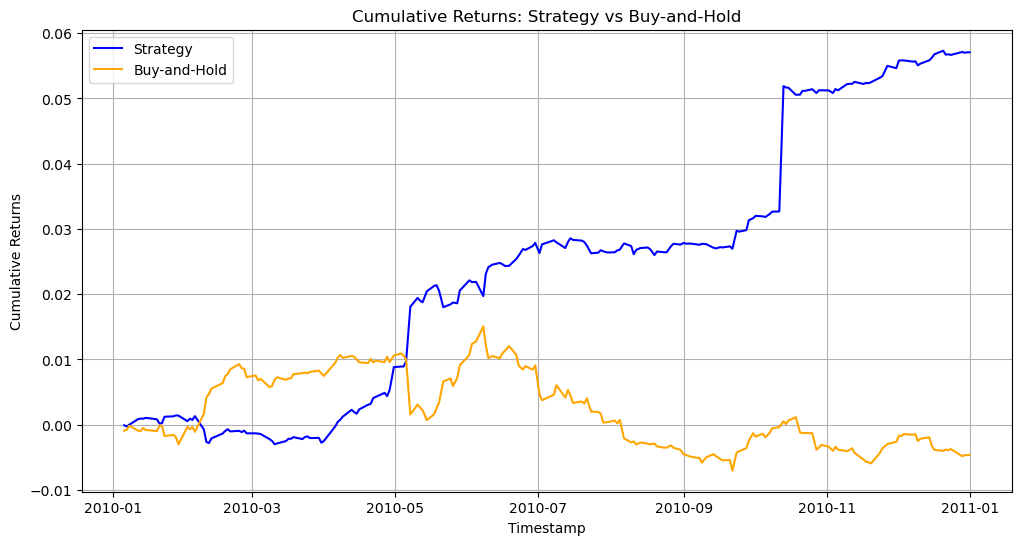

In [23]:
def plot_second_strategy(returns_df):
    """
    Plot cumulative returns for the strategy, and buy-and-hold portfolio.

    Parameters:
    - returns_df (pd.DataFrame): DataFrame with strategy, and buy-and-hold returns.
    """
    # Compute cumulative returns
    cumulative_portfolio = (1 + returns_df['portfolio']).cumprod() - 1
    cumulative_buy_and_hold = (1 + returns_df['buy_and_hold']).cumprod() - 1

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(returns_df['timestamp'], cumulative_portfolio, label="Strategy", color='blue')
    plt.plot(returns_df['timestamp'], cumulative_buy_and_hold, label="Buy-and-Hold", color='orange')
    plt.xlabel("Timestamp")
    plt.ylabel("Cumulative Returns")
    plt.title("Cumulative Returns: Strategy vs Buy-and-Hold")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_second_strategy(returns_df)

The Momentum-Weighted Market State Strategy demonstrates the potential of incorporating momentum-based weighting into clustering-derived market states. The results highlight the value of momentum filtering in adaptive trading strategies.